In [1]:
import torch
from torch import nn

import math
import matplotlib.pyplot as plt

In [2]:
torch.manual_seed(111)

In [3]:
train_data_length = 1024

train_data = torch.zeros((train_data_length, 2))
train_data[:, 0] = 2 * math.pi * torch.rand(train_data_length)
train_data[:, 1] = torch.sin(train_data[:, 0])
train_label = torch.zeros(train_data_length)

train_set = [(train_data[i], train_label[i]) for i in range(train_data_length)]

In [4]:
train_set[:10]

[(tensor([ 4.4960, -0.9767]), tensor(0.)),
 (tensor([ 5.7428, -0.5145]), tensor(0.)),
 (tensor([1.7710, 0.9800]), tensor(0.)),
 (tensor([1.6217, 0.9987]), tensor(0.)),
 (tensor([ 3.9654, -0.7337]), tensor(0.)),
 (tensor([ 3.7702, -0.5881]), tensor(0.)),
 (tensor([ 5.8509, -0.4190]), tensor(0.)),
 (tensor([1.3527, 0.9763]), tensor(0.)),
 (tensor([ 3.7905, -0.6043]), tensor(0.)),
 (tensor([ 4.6042, -0.9942]), tensor(0.))]

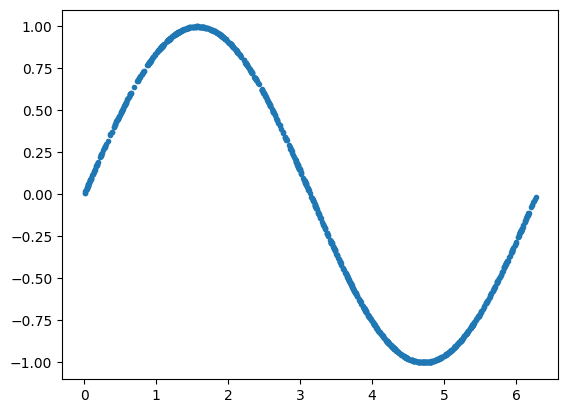

In [5]:
plt.plot(train_data[:, 0], train_data[:, 1], ".")

In [6]:
batch_size = 32

train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)

In [7]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(2, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        output = self.model(x)
        return output
    


In [8]:
discriminator = Discriminator()
discriminator

Discriminator(
  (model): Sequential(
    (0): Linear(in_features=2, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=256, out_features=128, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=128, out_features=64, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.3, inplace=False)
    (9): Linear(in_features=64, out_features=1, bias=True)
    (10): Sigmoid()
  )
)

In [9]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(2, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 2),
        )
        
    def forward(self, x):
        output = self.model(x)
        return output
    
    

In [10]:
generator = Generator()
generator

Generator(
  (model): Sequential(
    (0): Linear(in_features=2, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=2, bias=True)
  )
)

### BCELoss

Binary Cross Entropy Loss (BCE) is a commonly used loss function in binary classification tasks. It measures the difference between the predicted probabilities and the actual binary labels. It helps the model understand how far its predictions are from the true binary outcomes (0 or 1) and guides it to minimize this difference.

$$
\text{BCE Loss} = - \frac{1}{N} \sum_{i=1}^{N} \left[ y_i \log(p_i) + (1 - y_i) \log(1 - p_i) \right]
$$

In [11]:
lr = 0.001
num_epochs = 1000
loss_function = nn.BCELoss()

In [12]:
discriminator_optimizer = torch.optim.Adam(discriminator.parameters(), lr=lr)
generator_optimizer = torch.optim.Adam(generator.parameters(), lr=lr)

In [13]:
for epoch in range(num_epochs):
    for n, (real_samples, _) in enumerate(train_loader):
        # Data for training the discriminator
        real_samples_labels = torch.ones((batch_size, 1))
        latent_samples = torch.randn((batch_size, 2))
        
        generated_samples = generator(latent_samples)
        generated_samples_labels = torch.zeros((batch_size, 1))
        
        all_samples = torch.cat((real_samples, generated_samples))
        all_samples_labels = torch.cat((real_samples_labels, generated_samples_labels))
        
        # Train the discriminator
        discriminator.zero_grad()
        output_discriminator = discriminator(all_samples)
        
        loss_discriminator = loss_function(output_discriminator, all_samples_labels)
        loss_discriminator.backward()
        discriminator_optimizer.step()
        
        
        # Data for training the generator
        latent_space_samples = torch.randn((batch_size, 2))
        
        # Train the generator
        generator.zero_grad()
        generated_samples = generator(latent_space_samples)
        output_discriminator_generated = discriminator(generated_samples)
        
        loss_generator = loss_function(output_discriminator_generated, real_samples_labels)
        loss_generator.backward()
        generator_optimizer.step()
        
        if epoch % 10 == 0 and n == batch_size - 1:
            print(f"Epoch: {epoch} Loss D.: {loss_discriminator}")
            print(f"Epoch: {epoch} Loss G.: {loss_generator}")
        
        

Epoch: 0 Loss D.: 0.6061952710151672
Epoch: 0 Loss G.: 1.442305564880371
Epoch: 10 Loss D.: 0.5353243947029114
Epoch: 10 Loss G.: 0.7068256139755249
Epoch: 20 Loss D.: 0.7080711126327515
Epoch: 20 Loss G.: 0.7180628180503845
Epoch: 30 Loss D.: 0.7057681083679199
Epoch: 30 Loss G.: 0.7880392074584961
Epoch: 40 Loss D.: 0.6659220457077026
Epoch: 40 Loss G.: 0.8903871178627014
Epoch: 50 Loss D.: 0.700967013835907
Epoch: 50 Loss G.: 0.6452773809432983
Epoch: 60 Loss D.: 0.6829605102539062
Epoch: 60 Loss G.: 0.8682596683502197
Epoch: 70 Loss D.: 0.6928033828735352
Epoch: 70 Loss G.: 0.6713805198669434
Epoch: 80 Loss D.: 0.6948362588882446
Epoch: 80 Loss G.: 0.6822545528411865
Epoch: 90 Loss D.: 0.701011598110199
Epoch: 90 Loss G.: 0.6971438527107239
Epoch: 100 Loss D.: 0.6928802132606506
Epoch: 100 Loss G.: 0.676943838596344
Epoch: 110 Loss D.: 0.6979297399520874
Epoch: 110 Loss G.: 0.7084340453147888
Epoch: 120 Loss D.: 0.6898257732391357
Epoch: 120 Loss G.: 0.7351680397987366
Epoch: 130 L

In [14]:
latent_space_samples = torch.randn((500, 2))
generated_samples = generator(latent_space_samples)
generated_samples = generated_samples.detach()

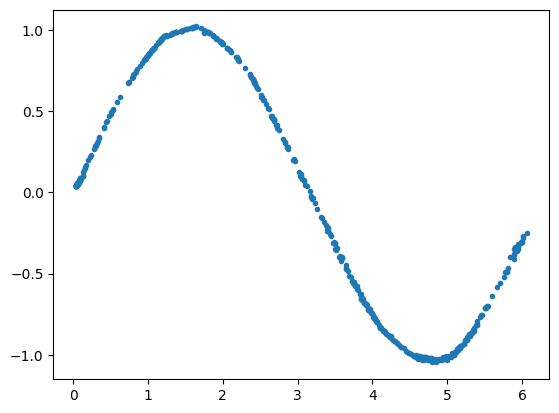

In [15]:
plt.plot(generated_samples[:, 0], generated_samples[:, 1], ".")